# Title

## Business Overview

### The problem

We were tasked with providing Computing Vision a series of suggestions for their transition into the film industry. Specifically, we aimed to determine suggestions that could target higher levels of revenue and/or profit.

### The goal

The film industry is a creative and diverse market with several avenues to success. With the understanding that there is no one path to success, we aimed to generate insight into a variety of actions Computing Vision may want to take in order to carve their own unique path to success. To accomplish this goal, we analyzed several different facets of films and their relation to generating revenue and profit. These areas included genres, day of release, and experience level of directors. 

## The Datasets

The range of our analyses required utilization of several datasets. For each area of analysis, we used:

Directors:

Release Day:

Genres:
- Movie Budgets dataset from (INSERT SOURCE HERE). Including movie titles, production budget, and worldwide gross revenue. 
- TMDB dataset including movie titles and genres.

## The Methods and Results

# Imports

##  DIMA
### Experience Level of Directors in relation to Profit

***The Business Question***

Does the expertise of the director affect the movie's profitability?

***The Datasets***

In this section, we used the following datasets:

- Movie Info dataset from Rotten Tomatoes which included the Director column required for this analysis.
- Movie Budgets dataset from The-Numbers which included the movie titles, production budget, and worlwide gross which we used to calculate the profit which is our main measure of success in the project

To explore the data we will first start off with importing the necessary libraries needed.

In [2]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_iris
from pandas import Series, DataFrame

%matplotlib inline

### Movie Info
Starting with the movie info dataframe, the first step is to read into the tsv file

In [3]:
# Read in the data as movie_info
# Use parse_dates and pass column name to read it as a datetime
movie_info = pd.read_csv('../Data/rt.movie_info.tsv', encoding='latin-1', sep='\t', 
                        parse_dates=['theater_date', 'dvd_date'])
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaT,NaT,NaN,NaN,200 minutes,NaN


#### Data Cleaning
In this section, we will start by cleaning the movie_info dataframe before we can draw any conclusions. It will help us inspect the data better and get a more accurate general understanding of the data at hand.

Step 1: Check if we have any null values in each column

In [4]:
movie_info.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

Step 2: Dealing with null values

To clean the columns from null values, we will be replacing the null values in the column with generic terms relevant to each column so that it's all consistent across the columns.

In [5]:
#Fill the missing values in synposis, genre, director, writer, currency, studio with 'Missing'
movie_info['synopsis'].fillna('Missing', inplace=True)
movie_info['rating'].fillna('Missing', inplace=True)
movie_info['genre'].fillna('Missing', inplace=True)
movie_info['director'].fillna('Missing', inplace=True)
movie_info['writer'].fillna('Missing', inplace=True)
movie_info['currency'].fillna('Missing', inplace=True)
movie_info['studio'].fillna('Missing', inplace=True)

In [6]:
#Fill theater_date and dvd_date missing values with a generic date "1800-01-01" to keep same format
movie_info['theater_date'].fillna('1800-01-01', inplace=True)
movie_info['dvd_date'].fillna('1800-01-01', inplace=True)

In [7]:
#Fill box_office missing valus with 0
movie_info['box_office'].fillna(0, inplace=True)

In [10]:
#Fill runtime missing valus with 0
movie_info['runtime'].fillna('0 minutes', inplace=True)

#Change the type of data so that we are able to use it later on if we needed to.
movie_info['runtime'] = movie_info['runtime'].str.replace('minutes',"")
movie_info['runtime'] = pd.to_numeric(movie_info['runtime'])

Step 3: check for any duplicates

In [11]:
movie_info.duplicated().value_counts()

False    1560
dtype: int64

It doesn't look like we have any duplicates. In this case, we are good to proceed forward.

#### Analysis methods

In this section, We will look into the Director column within this data frame to see if the Director's expertise affects the movie's success.

The question being analyzed is whether the expertise of the director affects the movie's profitability.

We will look at the count of movies directed per director, as directors with more experience could potentially yield higher profit due to their expertise.

- First, we will look at the budgets table.
- Second, we want to look at the trend between the count of movies per director and the profit
    - To do that, we will merge the budget dataframe and movie_info dataframe to check the profit generated by each director.
- Third, we will sort the top directors with the highest average profit.

We will start by reading into the budgets table and cleaning it

In [14]:
#reading into the csv data file
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In this table we will assume that **Revenue** = 'worldwide_gross' & **Cost** = 'production_budget'

In [15]:
#will follow Morgan's data cleaning for this table
# removing $ and , from gross revenue
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",","")
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$","")

# casting the values as integers
budgets['worldwide_gross'] = pd.to_numeric(budgets['worldwide_gross'])

# removing $ and , from production budget
budgets['production_budget'] = budgets['production_budget'].str.replace(",","")
budgets['production_budget'] = budgets['production_budget'].str.replace("$","")

# casting the values as integers
budgets['production_budget'] = pd.to_numeric(budgets['production_budget'])

In [16]:
# calculating total profit = revenue - cost
budgets['total_profit'] =  budgets['worldwide_gross'] - budgets['production_budget']

From here on we will be comparing the total profit from the budgets table to the Directors in the movie_info table.

Since we don't need all the columns in the dataframe, we will create a new one with only the columns necessary to the analysis.

In [18]:
movie_budgets = budgets[['id','movie','worldwide_gross','total_profit']]

### Merging movie_info & budget dataframes

We will join the dataframes using an **inner** join because it returns only the records with matching keys in both tables, we will make a separate dataframe for the joined dataframes.

In [19]:
movie_info_budget = movie_budgets.join(movie_info, how='inner', lsuffix = '_movie_budgets' , rsuffix = '_movie_info')
#checking the resulting dataframe
movie_info_budget.head()

,id_movie_budgets,movie,worldwide_gross,total_profit,id_movie_info,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,Avatar,2776345279,2351345279,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104,Missing
1,2,Pirates of the Caribbean: On Stranger Tides,1045663875,635063875,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108,Entertainment One
2,3,Dark Phoenix,149762350,-200237650,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13 00:00:00,2000-04-18 00:00:00,Missing,0,116,Missing
3,4,Avengers: Age of Ultron,1403013963,1072413963,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09 00:00:00,1997-08-27 00:00:00,Missing,0,128,Missing
4,5,Star Wars Ep. VIII: The Last Jedi,1316721747,999721747,7,Missing,NR,Drama|Romance,Rodney Bennett,Giles Cooper,1800-01-01,1800-01-01,Missing,0,200,Missing


In [20]:
#I want to check how many 0 we have for worldwide gross, we can see if the minimum number is 0
movie_info_budget['worldwide_gross'].describe()

count    1.560000e+03
mean     2.374879e+08
std      2.686596e+08
min      0.000000e+00
25%      6.806081e+07
50%      1.523167e+08
75%      3.029080e+08
max      2.776345e+09
Name: worldwide_gross, dtype: float64

To deal with these values, we decided to replace it with the median profit because the median is more resilient against extreme outliers.

In [21]:
median_gross = movie_info_budget['worldwide_gross'].median()
movie_info_budget['worldwide_gross'] = movie_info_budget['worldwide_gross'].replace(0,median_gross)

We will now start looking if there are any trends between the expertise of the director vs. the profit

In [22]:
#Create top directors df so that we can visualize top directors and top profit
#The count will show us the count of movies each director has worked on
director_counts = pd.DataFrame(movie_info_budget.groupby('director')['movie'].count())

#We are summing the profit of all the movies per director into the total profit
director_total_profit = pd.DataFrame(movie_info_budget.groupby('director')['total_profit'].sum())

In [23]:
# I will now join the director counts and total profit together into a new df, I will also sort it by total profit
top_directors = director_counts.join(director_total_profit, how='outer', lsuffix = '_director_counts' , rsuffix = 'director_total_profit')
top_directors = top_directors.sort_values(by='total_profit', ascending=False)

In [24]:
#Dropping the missing values
top_directors = top_directors.drop(labels="Missing")

In [25]:
#We will add the average profit per director since it would be more accurate to look at it than Total profit
top_directors['avg_profit'] =  top_directors['total_profit']/top_directors['movie']
top_directors['avg_profit'] = top_directors['avg_profit'].sort_values(ascending=False)
top_directors

,movie,total_profit,avg_profit
director,,,
William Friedkin,4,2705957834,6.764895e+08
Henning Schellerup,1,2008208395,2.008208e+09
Steven Spielberg,10,1777836004,1.777836e+08
Jake Kasdan,1,1748134200,1.748134e+09
Jay Russell,1,1747311220,1.747311e+09
...,...,...,...
Robert Hartford-Davis,1,-94635231,-9.463523e+07
Renny Harlin,2,-111069937,-5.553497e+07
Richard Thorpe,2,-117780537,-5.889027e+07


Now to visualize the results we will display it using a boxplot to display the spread of the data.

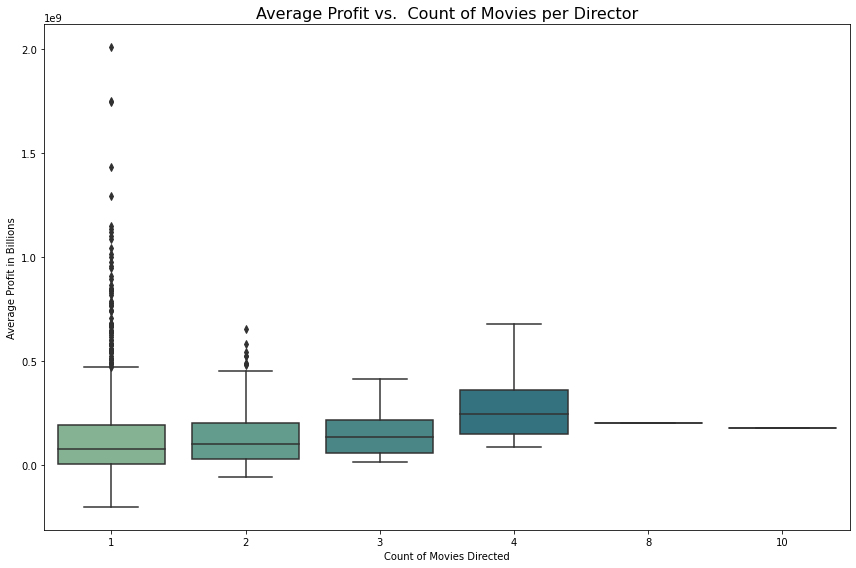

In [29]:
# We will visualize the results
# Plot average profit vs. count of movies directed 
plt.figure(figsize=(12,8))
sns.boxplot(x = top_directors['movie'], y = top_directors['avg_profit'], palette='crest')
plt.title('Average Profit vs.  Count of Movies per Director', fontsize=16)
plt.xlabel('Count of Movies Directed')
plt.ylabel('Average Profit in Billions')
plt.tight_layout()
plt.show()


The trend that the boxplot reflects is that directors that have directed 3 or more movies have always had an average profit that is positive. We can see that the minimum for 3 movies is always positive. 

The are many outliers for Directors with just one movie, and a few in those with 2 movies, but as we move to directing 3 or more we don't see as many outliers. Therefore, we can conclude that as these Directors worked on more movies, the factor of luck has been eliminated and they've continued to be profitable.

Drawing from this trend, going forward we will look at the top 20 directors in terms of average profit that directed 3 or more movies.

In [27]:
#Getting the top 20 directors that directed 3 or more movies
three_plus_movies = top_directors[(top_directors['movie'] >= 3)].head(20)
three_plus_movies = three_plus_movies.reset_index()
three_plus_movies

,director,movie,total_profit,avg_profit
0,William Friedkin,4,2705957834,6.764895e+08
1,Steven Spielberg,10,1777836004,1.777836e+08
2,Clint Eastwood,8,1607570579,2.009463e+08
3,Woody Allen,4,1546517681,3.866294e+08
4,Yimou Zhang,4,1458132256,3.645331e+08
5,Barry Levinson,4,1435779099,3.589448e+08
6,Boris Sagal,3,1237332495,4.124442e+08
7,Jim Jarmusch,4,1050825592,2.627064e+08
8,Werner Herzog,3,911024954,3.036750e+08
9,Howard Hawks,3,909512843,3.031709e+08


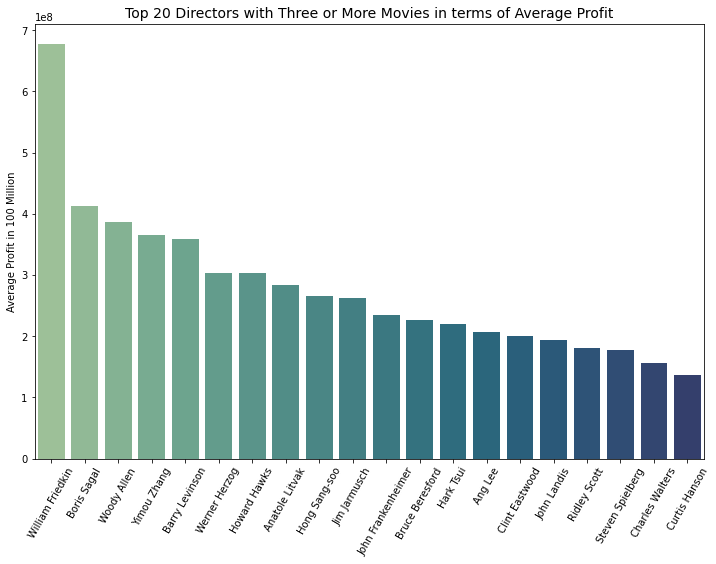

In [28]:
#now let's visualize the results
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x = three_plus_movies['director'], y = three_plus_movies['avg_profit'], order= three_plus_movies.sort_values('avg_profit',ascending = False).director, palette="crest")
plt.xticks(rotation=60)
plt.xlabel(None)
plt.ylabel('Average Profit in 100 Million')
plt.title('Top 20 Directors with Three or More Movies in terms of Average Profit', fontsize=14)
plt.show();

This barplot displays the top 20 directors in terms of average profit that have directed 3 or more movies. Drawing from this, if Computing Vision has the budget they could potentially hire one of these directors, or they can look into their work and get inspired by it.

#### Conclusion / Suggestion

In the context of this project an experienced director is defined as a director that has directed three or more movies.

Since Computing Vision is a new studio that is just starting in the movie industry, we ***recommend*** that they hire an experienced director that has experience directing three or more movies since our analysis showed that it is likely for these directors to continue being profitable on the 4th movie. 

According to our analysis, experienced directors always resulted in positive average profit. While directors with less than 3 movies can also be profitable, however, going through a risk averse route and eliminating the factor of luck from success, experienced directors have proved to be profitable on the third movie and on.

#### What limitations are there?

One limitation that could be pointed out could be that there is a survival bias in the research, in which survival bias is defined as a type of sampling error or selection bias that occurs when the selection process of a trial favours certain individuals who made it past a certain obstacle or point in time and ignores the individuals who did not. In our case it would be selecting Directors with three or movies, and ignoring the ones with less experience. However, we concluded that for a new studio it is preferable that on their first projects that they take a route that is proven to be successful and taking less risks and that is by hiring an experienced director to direct their movies. 

Another limitation is in the case of trying to recommend to hire one of the top 20 Directors in terms of their average profit and their expertise, a limitation was that some of the top 20 directors are in fact deceased. Deceased Directors: Boris Karloff, Howard Hawks, Anatole Litvak, John Frankenheimer, Charles Walters, Curtis Hanson.

However, in light of this limitation, a business suggestion here would be to look into these directors' work and potentially acquiring the rights to their work if possible and generate profit off of that.

## LEO
### Day of Release as a Predictor of Revenue
### Project Goals, Data, Methods, and Results:
In this notebook you will find my data cleaning, organiztion, and results for the Capstone Project.

In essence we like to keep things as straight forward as possiable. Our goal here is to demostrate that we understand the data and that we are confident in making relevant connections. 

We decided that a simple and very relevant business recommendation is what day of the week a movie should be released. Why is this important? Money, more specifically when it comes to box office sales/revenue. 

When it comes to products, be it a pair of shoes, watch, or in this case a Movie, We want to release these products on the day that yields the most money. 

Therefore, based on this goal we will go through the data and search for the desired day of the week that shows most box office sales. Very simple and straight forward. 

In [ ]:
# starting with significant imports 
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import datetime 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import scipy.stats
import scipy.optimize
import scipy.spatial
from IPython import display
from ipywidgets import interact, widgets

import re
import mailbox
import csv
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

#### Datasets and cleaning

In [5]:
# Load data
movie_info = pd.read_csv('../data/rt.movie_info.tsv', sep="\t")
movie_info.head(10)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN
9,15,When a diamond expedition in the Congo is lost...,PG-13,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,NaN,108 minutes,NaN


In [6]:
# Basic info in the data
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [7]:
# making the box office data type a float and getting rid of the commas
movie_info['box_office'] = pd.to_numeric(movie_info['box_office'].str.replace(',', ''))

In [10]:
# turning the theater_date column into a datetime object
movie_info['theater_date'] = pd.to_datetime(movie_info['theater_date'], format='%b %d, %Y')

In [11]:
# making sure that the datetime changed
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,"Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,"Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,"Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaT,NaN,NaN,NaN,200 minutes,NaN


In [14]:
# now we can create another column so that we can refrence what day the movies came out.
# we can simply make a column with these days
movie_info['day_of_week'] = movie_info['theater_date'].dt.day_name()

In [16]:
# here we want to see the value count for each day.
# this will give us a picture of what days have a high count
movie_info['day_of_week'].value_counts()

Friday       702
Wednesday    169
Thursday      95
Saturday      76
Monday        60
Tuesday       53
Sunday        46
Name: day_of_week, dtype: int64

In [17]:
# dropping null values in te box office column
movie_info = movie_info.dropna(subset=['box_office'])

In [18]:
# making sure the nulls are gone
movie_info['box_office'].isnull().sum()

0

In [19]:
# starting a new dataframe with the columns we want to further inspect
new_subset = movie_info[['theater_date', 'box_office', 'day_of_week']]

In [20]:
# resetting the index
new_subset.reset_index(drop=True, inplace=True)

In [22]:
# inspecting the null values that i have.
new_subset.isnull().sum()

theater_date    6
box_office      0
day_of_week     6
dtype: int64

In [23]:
# dropping nulls
new_subset = new_subset.dropna(subset=['theater_date'])

In [24]:
new_subset = new_subset.dropna(subset=['day_of_week'])

In [26]:
# making a new dataframe with the desired columns for further analysis.
# also sorted them.
final_subset = new_subset[['theater_date', 'box_office', 'day_of_week']]
final_subset.sort_values(['box_office', 'day_of_week'], inplace=True)

In [33]:
# a way to remove this redundancy is to create a separate table with days data and linking it to the box office using-
# an index. this is called data normalization.
days = final_subset[['day_of_week', 'box_office']].drop_duplicates()
days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 205 to 169
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day_of_week  331 non-null    object 
 1   box_office   331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB


In [35]:
# since the index is unique we need to carry it explicitly as a column.
# we will reset the index and rename it id
days.index.name = 'id'
my_id = days.reset_index()
my_id.head()

,id,day_of_week,box_office
0,205,Friday,363.0
1,76,Friday,2367.0
2,145,Friday,3328.0
3,143,Wednesday,8300.0
4,278,Friday,8856.0
5,298,Friday,16632.0
6,101,Friday,22099.0
7,137,Wednesday,25658.0
8,180,Friday,35966.0
9,127,Friday,39712.0


In [36]:
# merging together
pd.merge(my_id, days, on=['day_of_week', 'box_office']).head()

,id,day_of_week,box_office
0,205,Friday,363.0
1,76,Friday,2367.0
2,145,Friday,3328.0
3,143,Wednesday,8300.0
4,278,Friday,8856.0


In [37]:
# heres a simplified table
tidy = pd.merge(my_id, days, on=['day_of_week', 'box_office'])
tidy.sort_values(['box_office', 'day_of_week'], inplace=True)

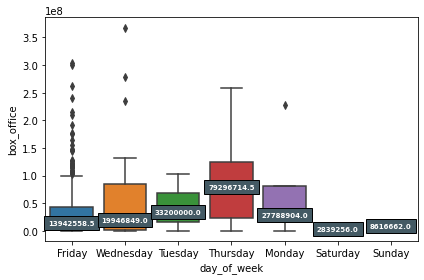

In [39]:
box_plot = sns.boxplot(x="day_of_week", y="box_office", data=tidy)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=7,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout()

#### Analysis methods
Most of the analysis methods used were filters, and pandas functions. We also used datetime manipulation which made things easier. 

We also used the box plot above to describe our findings. Overall, pretty straight forward. 

#### Conclusion / Suggestion
Based on the findings on box office revenue and day of the week that the movie was released, Friday is the best day to release a movie. Since the majority of the movies come out on Friday, the biggest yield in box office revenue is Friday.

#### Therefore, we can recommend that Computing Vision should relese their movies on Friday to maximize box office revenue

These findings are important because a company like Computing Vision, that is starting off in the movie industry should maximize those box office sales.

#### What limitations are there?
The only limitations we can think of is that the sample size is not big enough. This does not allow for more accurate testing. 

The outliers for Friday were pretty significant as well. Compared to the other days, Friday's box is tight meaning that there is not a lot of varience compared with the other outliers. 

### Genre as a Predictor of Revenue (Chi Square Analysis)

#### The Business Question
Does the genre of a movie have any association with the movie's profitability?

#### The Datasets
- Movie Budgets dataset from (INSERT SOURCE HERE) including movie titles, production budget, and worldwide gross revenue. 
- TMDB dataset including movie titles and genres

#### The Methods

##### Import and Clean Data

We began with importing all relevant libraries for analysis and visualization. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

The relevant datasets for our analysis were the tn.movie_budgets.csv and tmdb.movies.csv files. 

In [2]:
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
tmdb = pd.read_csv("../data/tmdb.movies.csv", index_col = 0)

Before running our analysis, we needed to review the contents of the datasets, isolate relevant columns, and clean data as necessary.

First, we looked at the first few rows of the movie budgets dataframe in order to get an idea of the columns, potential datatypes, and areas which may require pre-processing and cleaning. 

In [3]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


From this dataframe, we decided that we needed to retain the following columns:
- Movie (for joining with other dataframes)
- Production Budget and Worldwide Gross (for calculating profit)

Thus, we formed a subset of the dataset including only the relevant columns.

In [4]:
cols_to_keep = ['movie','production_budget','worldwide_gross']
budgets_relevant = budgets[cols_to_keep]
budgets_relevant.head()

,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"


We also noted that the production budget and worldwide gross columns were populated with strings (as evident by the symbolic characters used alongside the numeric characters, such as "$"). These values needed to be cleaned and cast as integers before they could be used to calculate profit. 

However, before doing any further cleaning we looked for null values and duplicates so that we could avoid making any unnecessary calculations

In [5]:
budgets_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movie              5782 non-null   object
 1   production_budget  5782 non-null   object
 2   worldwide_gross    5782 non-null   object
dtypes: object(3)
memory usage: 135.6+ KB


Looking at the dataframe's information confirmed that the values within the production_budget and worldwide_gross columns were stored as strings and required cleaning. Furthermore, we could see that there were no obvious nulls in the dataframe. However, looking at the values stored within the worldwide_gross column brought to light some null-esque values. Namely, movies with a worldwide gross revenue of $0. 

In [6]:
budgets_relevant['worldwide_gross'].value_counts()

$0             367
$8,000,000       9
$2,000,000       6
$7,000,000       6
$4,000,000       4
              ... 
$14,942,422      1
$48,425,971      1
$6,100,000       1
$6,551,310       1
$76,904,429      1
Name: worldwide_gross, Length: 5356, dtype: int64

There were some zeroes in this column, presumably because there was no available data on its gross revenue. Rather than removing these observations, we decided to replace them with the median once the column had been properly cleaned. 

From here, we moved on to locating duplicate values. 

In [7]:
budgets_relevant.duplicated().value_counts()

False    5782
dtype: int64

There were no obvious duplicate rows. However, we realized that multiple movies could have the same title. This would pose an issue when we needed to join dataframes using movie titles as the mutual column. 

In [8]:
budgets_relevant['movie'].value_counts()

King Kong                             3
Halloween                             3
Home                                  3
Cinderella                            2
Twilight                              2
                                     ..
Blue Crush                            1
The Deep End                          1
Any Given Sunday                      1
Das Boot                              1
Terminator 3: Rise of the Machines    1
Name: movie, Length: 5698, dtype: int64

First, we looked into how many duplicate titles there were and if it was worth it to persue a method of merging the dataframes on two columns.

In [9]:
def get_title_counts(data, col):
    
    # set the value counts as a dataframe
    title_counts = pd.DataFrame(data[col].value_counts())
    
    # reset index so that we can easily access the titles
    title_counts = title_counts.reset_index()
    
    # take a subset of the title counts dataframe for all titles that appear more than once
    title_counts = title_counts.loc[ title_counts[col] > 1 ]
                                    
    # return this dataframe of title duplicates                                
    return title_counts

title_counts = get_title_counts(budgets_relevant, 'movie')
title_counts

,index,movie
0,King Kong,3
1,Halloween,3
2,Home,3
3,Cinderella,2
4,Twilight,2
...,...,...
76,Peteâs Dragon,2
77,Hamlet,2
78,Flatliners,2
79,Teenage Mutant Ninja Turtles,2


81 rows out of a 5,000+ row dataset didn't seem substantial enough to justify the attempted mutli-column merge given the time contraints of the project. So, we decided to simply drop the duplicates.

In [10]:
def remove_duplicate_titles(data, col):
    
    # get the dataframe for titles which appear more than once
    title_counts = get_title_counts(data,col)
    
    # create a dichotomous column for which there is a 1 if the movie is a duplicate title
    data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)
    
    # take a subset of the dataframe of only non-duplicate titles
    data = data.loc[ data['duplicate'] == 0]
    
    # initialize a list of columns to maintain
    keepers = []
    
    # for each column in the dataframe
    for col in data.columns:
        # if it isn't the duplicate column
        if col != "duplicate":
            # add it to the list of columns to be maintained
            keepers.append(col)
    
    # keep only the columns intended
    data = data[keepers]
        
    return data

budgets_relevant = remove_duplicate_titles(budgets_relevant, 'movie')
budgets_relevant

<ipython-input-10-de8f23511d27>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)


,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"
...,...,...,...
5777,Red 11,"$7,000",$0
5778,Following,"$6,000","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338"
5780,A Plague So Pleasant,"$1,400",$0


After checking for nulls and duplicates, we got started cleaning the budget and gross revenue columns so that we could eventually use them to calculate profit. 

In [11]:
def dollar_to_numeric(column):
    # removing $ and , from string
    column = column.str.replace(",","")
    column = column.str.replace("$","")

    # casting the values as integers
    column = pd.to_numeric(column)
    
    return column

budgets_relevant['worldwide_gross'] = dollar_to_numeric(budgets_relevant['worldwide_gross'])
budgets_relevant['production_budget'] = dollar_to_numeric(budgets_relevant['production_budget'])

budgets_relevant.head()

,movie,production_budget,worldwide_gross
0,Avatar,425000000,2776345279
1,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875
2,Dark Phoenix,350000000,149762350
3,Avengers: Age of Ultron,330600000,1403013963
4,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747


After successfully casting the data as integers, we looked at the descriptive statistics for any obvious issues.

In [12]:
budgets_relevant['production_budget'].describe()

count    5.459000e+03
mean     3.112546e+07
std      4.134343e+07
min      1.100000e+03
25%      5.000000e+06
50%      1.700000e+07
75%      4.000000e+07
max      4.250000e+08
Name: production_budget, dtype: float64

In [13]:
budgets_relevant['worldwide_gross'].describe()

count    5.459000e+03
mean     8.940551e+07
std      1.721636e+08
min      0.000000e+00
25%      3.808364e+06
50%      2.709288e+07
75%      9.655151e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

There are some zeroes in the worldwide gross revenue dataset. Since this most likely implies missing data, we looked to see how many rows this is the case for.

In [14]:
budgets_relevant['worldwide_gross'].value_counts()

0            355
8000000        7
7000000        6
2000000        6
4000000        4
            ... 
58545540       1
92618117       1
834953         1
190453132      1
310946         1
Name: worldwide_gross, Length: 5054, dtype: int64

Since this is a pretty substantial number of movies, but not a significant proportion of the dataset, we decided to impute these values with the median profit. The decision was made to use the median rather than the mean because of its resiliency against extreme outliers.

In [15]:
median_gross = budgets_relevant['worldwide_gross'].median()
budgets_relevant['worldwide_gross'] = budgets_relevant['worldwide_gross'].replace(0,median_gross)
budgets_relevant['worldwide_gross'].describe()

count    5.459000e+03
mean     9.116737e+07
std      1.713763e+08
min      2.600000e+01
25%      7.833752e+06
50%      2.709288e+07
75%      9.655151e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

Now that we had two clean revenue and cost columns to work with, we used this information to create a new column in the dataframe for the calculated profit. 

In [16]:
# calculating total profit
budgets_relevant['total_profit'] =  budgets_relevant['worldwide_gross'] - budgets_relevant['production_budget']

budgets_relevant = budgets_relevant[['movie','total_profit']]

# confirmation
budgets_relevant['total_profit'].describe()

count    5.459000e+03
mean     6.004190e+07
std      1.431806e+08
min     -2.002376e+08
25%     -1.394899e+06
50%      1.415149e+07
75%      5.964086e+07
max      2.351345e+09
Name: total_profit, dtype: float64

Next, we decided to visualize the distribution of profit since this is our dependent variable.

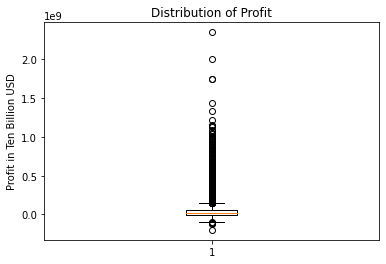

In [17]:
fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Ten Billion USD");

It was evident that there were some extremely profitable (and extremely unprofitable) movies that may influence the results of our analysis. Because of the presense of extremes, we decided to remove any movies with profits outside of the interquartile range.

Resource used: https://www.statology.org/remove-outliers-python/

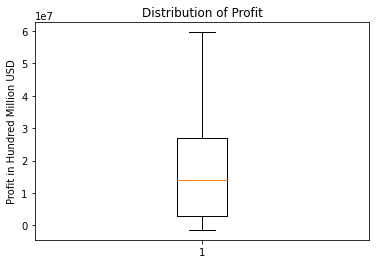

In [18]:
# find Q1, Q3, and interquartile range for each column
Q1 = budgets_relevant['total_profit'].quantile(q=.25)
Q3 = budgets_relevant['total_profit'].quantile(q=.75)
IQR = budgets_relevant['total_profit'].apply(stats.iqr)

budgets_relevant = budgets_relevant.loc[~((budgets_relevant['total_profit'] < (Q1-1.5*IQR)) | (budgets_relevant['total_profit'] > (Q3+1.5*IQR)))]

fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Hundred Million USD");

Knowing that we would eventually have to merge this dataframe with the TMDB dataframe, we also set the index to the column on which we wanted to merge (the movie title). 

In [19]:
budgets_relevant.set_index('movie', inplace = True)
budgets_relevant.head()

,total_profit
movie,
John Carter,7778100
Green Lantern,19535492
Jack the Giant Slayer,2687603
Hugo,47784
Valerian and the City of a Thousand Planets,35098356


With this dataframe cleaned, we moved on to the TMDB dataframe.

Just like the first dataframe, we began by looking at the first few rows to get an idea of the columns, datatypes, and areas which may require preprocessing/cleaning. 

In [20]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


From this dataframe, we noted that we only needed the following columns:
- Title (for merging)
- Genre_ids

We started with dropping the irrelevant columns.

In [21]:
cols_to_keep = ['title','genre_ids']
tmdb_relevant = tmdb[cols_to_keep]
tmdb_relevant.head()

,title,genre_ids
0,Harry Potter and the Deathly Hallows: Part 1,"[12, 14, 10751]"
1,How to Train Your Dragon,"[14, 12, 16, 10751]"
2,Iron Man 2,"[12, 28, 878]"
3,Toy Story,"[16, 35, 10751]"
4,Inception,"[28, 878, 12]"


We noted that the genre_ids column appeared to contain lists of multiple ids associated with specific genres. We needed to clean this column and replace these numbers with their associated genre. However, we decided to wait to replace these values until after the dummy columns were created because it would be easier to rename a small number of columns than replace multiple numbers in every cell with its associated genre. 

So for now, we moved on to locating null values and duplicates.

In [22]:
tmdb_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      26517 non-null  object
 1   genre_ids  26517 non-null  object
dtypes: object(2)
memory usage: 621.5+ KB


There didn't appear to be any null values in the dataset.

In [23]:
tmdb_relevant.duplicated().value_counts()

False    25429
True      1088
dtype: int64

There were, however, some duplicate movies which we needed to drop.

In [24]:
tmdb_relevant = tmdb_relevant.drop_duplicates()
tmdb_relevant.duplicated().value_counts()

False    25429
dtype: int64

There were also more duplicate titles to remove. We handled these the same as we did in the budgets dataframe. 

In [25]:
tmdb_relevant['title'].value_counts()

Home                       6
Lucky                      5
The Gift                   5
Aftermath                  5
Alone                      4
                          ..
The Livingston Gardener    1
Spit                       1
Blood Road                 1
Viva Amiga                 1
Shark Exorcist             1
Name: title, Length: 24688, dtype: int64

In [26]:
tmdb_relevant = remove_duplicate_titles(tmdb_relevant,'title')
tmdb_relevant['title'].value_counts()

Architects & Engineers: Solving the Mystery of WTC 7    1
Kanye West: 808s & Heartbreak at The Hollywood Bowl     1
Nocturne                                                1
Ali's Wedding                                           1
24 Hour Comic                                           1
                                                       ..
Mike and I                                              1
Around the Block                                        1
Door to Door                                            1
Beating Hearts                                          1
Entwinement                                             1
Name: title, Length: 17714, dtype: int64

After dropping these duplicate values, we set the movie titles as in the index in preparation for merging these two dataframes.

In [27]:
tmdb_relevant = tmdb_relevant.set_index('title')
tmdb_relevant

,genre_ids
title,
How to Train Your Dragon,"[14, 12, 16, 10751]"
Iron Man 2,"[12, 28, 878]"
Toy Story,"[16, 35, 10751]"
Inception,"[28, 878, 12]"
Percy Jackson & the Olympians: The Lightning Thief,"[12, 14, 10751]"
...,...
Laboratory Conditions,"[27, 18]"
_EXHIBIT_84xxx_,"[18, 53]"
The Last One,"[14, 28, 12]"


Now that we had cleaned the data, it was ready to be merged.

In [28]:
budgets_and_tmdb = budgets_relevant.join(tmdb_relevant, how='inner')
budgets_and_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, John Carter to Newlyweds
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   total_profit  656 non-null    int64 
 1   genre_ids     656 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


After merging the dataframes, we were left with a much smaller dataframe than either of the parent datasets. This, however, was expected given there was no gaurantee that the datasets would overlap in their contents significantly nor was there a gaurantee that there would not be any spelling errors in the titles that would prevent a successful join for at least some rows. Given the timeframe of this project, we decided to proceed with the knowledge that 656 movies can still provide some useful insights.

The genre_ids column is made up of strings. This means that we needed to remove any string characters and isolate each genre id before making dummy columns. We needed to accomplish the following:
1. Remove brackets and whitespace
2. Split by commas
3. Create a new dataframe with genres as columns and cells containing binary values, with 1 indicating a relevant genre for that movie. 

For this section, we utilized this resource to create our dummy columns: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies

In [29]:
def create_dummy_cols(data, col):
    
    # remove [, ], and whitespace
    data[col] = data[col].str.strip("]")
    data[col] = data[col].str.strip("[")
    data[col] = data[col].str.replace(" ", "")
    
    # split genre ids by commas
    genre_ids = data[col].str.split(",")
    
    # create the binary dummy columns
    bin_genre_df = pd.get_dummies(genre_ids.apply(pd.Series).stack()).sum(level=0)
    budgets_and_genre_dummys = data.join(bin_genre_df, how='inner')
    
    # rename columns for genres
    budgets_and_genre_dummys.rename(columns = {'28' : 'Action', 
                                           '12' : 'Adventure',
                                          '16' : 'Animation',
                                          '35' : 'Comedy',
                                          '80' : 'Crime',
                                          '99' : 'Documentary',
                                          '18' : 'Drama',
                                          '10751' : 'Family',
                                          '14' : 'Fantasy',
                                          '36' : 'History',
                                          '27' : 'Horror',
                                          '10402' : 'Music',
                                          '9648' : 'Mystery',
                                          '10749' : 'Romance',
                                          '878' : 'SciFi',
                                          '10770' : 'TV',
                                          '53' : 'Thriller',
                                          '10752' : 'War',
                                          '37' : 'Western'}, inplace = True)
    return budgets_and_genre_dummys

budgets_and_genre_dummys = create_dummy_cols(budgets_and_tmdb,'genre_ids')
budgets_and_genre_dummys

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Horror,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exeter,464792,"53,27",0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Ten,27067880,"12,27,9648,53",0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
Dry Spell,27070880,"35,10749",0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
All Superheroes Must Die,27072880,"878,53",0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Note: there is a dummy column seemingly associated with no genre. This appears to be the result of some titles which did not have any associated genre id. So, we dropped them from analysis. 

In [30]:
budgets_and_genre_dummys = budgets_and_genre_dummys.loc[ (budgets_and_genre_dummys[''] != 1) ] 

We decided to turn profit into a categorical variable denoting high vs. medium vs. low profit. The threshold values for these categories were decided as:

- High = 75th percentile and greater
- Medium = Greater than 25th percentile and lower than 75th percentile.
- Low = 25th percentile and lower

In [31]:
# define thresholds
iqr_Q1 = budgets_and_genre_dummys['total_profit'].quantile(q=.25)
iqr_Q3 = budgets_and_genre_dummys['total_profit'].quantile(q=.75)

# assign categories based on thresholds
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] >= iqr_Q3, 'relative_profit_cat'] = 'high'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] <= iqr_Q1, 'relative_profit_cat'] = 'low'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['relative_profit_cat'].isna() , 'relative_profit_cat'] = 'medium'

budgets_and_genre_dummys.head()

C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary,relative_profit_cat
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,medium
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,medium
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,low
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,low
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,high


##### Chi-Square Analysis

In preparation for chi-square analysis, nwe built a contingency table with genres as rows and relative profit category as columns.

In [32]:
# initialize list of genres
genres = []

# for each column in the dataset
for column in budgets_and_genre_dummys.columns:
    # if it isn't a non-genre column
    ignored_cols = ['total_profit','title','relative_profit_cat','genre_ids','']  
    if column not in ignored_cols:
        # add it to the list of genres
        genres.append(column)
        
## Creating the contingency table

# create a dataframe with profit as columns and genres as rows
contingency_table = pd.DataFrame(columns = ['high', 'medium','low'], index = genres)

# replace the index (this is useful for using the numeric index to populate the dataframe in the next cell)
contingency_table.reset_index(inplace = True)

# fill the table with zeroes
contingency_table = contingency_table.fillna(0)
contingency_table.head()

,index,high,medium,low
0,Music,0,0,0
1,Romance,0,0,0
2,Family,0,0,0
3,War,0,0,0
4,TV,0,0,0


After creating the contingency table, we iterated through each row in the original dataframe to populate the contingency table based on genre and profit category. 

Resource: https://www.geeksforgeeks.org/how-to-set-cell-value-in-pandas-dataframe/

In [33]:
# for each row
for index, row in budgets_and_genre_dummys.iterrows():
    
    # for each column in that row that is a genre
    for col in budgets_and_genre_dummys.columns:
        
        if col not in ignored_cols:
    
            # if the cell value is 1
            if row[col] == 1 :
                
                # find the index associated with that genre in the contingency table
                genre_idx = contingency_table[contingency_table['index'] == col].index.values
                
                # look at the profit category column and save that value as well
                profit_cat = row['relative_profit_cat']
    
                # find the cell associated with that row index and profit column in the contingency table and add 1 
                contingency_table.loc[genre_idx, profit_cat] += 1   
                
contingency_table

,index,high,medium,low
0,Music,1,6,5
1,Romance,27,47,28
2,Family,17,23,6
3,War,3,5,2
4,TV,0,3,1
5,Adventure,22,32,10
6,Fantasy,12,15,12
7,Animation,10,14,2
8,Drama,71,163,99
9,Horror,24,50,18


We noted that there were some genres where there weren't many movies. To avoid drawing conclusions based on small sample sizes, we decided to filter out rows in the contingency table with row totals less than 50. 

In [34]:
contingency_table = contingency_table.loc[contingency_table['high'] + contingency_table['medium'] + contingency_table['low'] >= 50]
contingency_table = contingency_table.set_index('index')
contingency_table

,high,medium,low
index,,,
Romance,27,47,28
Adventure,22,32,10
Drama,71,163,99
Horror,24,50,18
Action,36,69,14
Comedy,55,103,47
Thriller,45,101,41
Crime,30,38,19
SciFi,15,27,9


With the contingency table populated and filtered for decent sample size, we were ready to conduct the chi-squared test.

Resource: https://www.geeksforgeeks.org/python-pearsons-chi-square-test/

In [35]:
from scipy.stats import chi2_contingency

# H_0 : Genre and Profit Level are not associated
# H_1: Genre and Profit Level are associated

stat, p, dof, expected = chi2_contingency(contingency_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.04456193254973362
Reject H_0


What this told us was that there was a significant association between these genres and relative profit categories. To dive deeper into the specifics, we needed to dichotomize our profit variable. 

We began with collapsing our medium and low profit categories into one category. This would allow us to see if there is a significant association between genres and higher profits. 

In [36]:
# Creating a copy of the contingency table
high_v_not_contingency = contingency_table.copy()

# Creating a new column to collapse the non-high profit categories into. 
high_v_not_contingency['not_high'] = high_v_not_contingency['medium'] + high_v_not_contingency['low']

# Isolating relevant columns
high_v_not_contingency = high_v_not_contingency[['high','not_high']]
high_v_not_contingency

,high,not_high
index,,
Romance,27,75
Adventure,22,42
Drama,71,262
Horror,24,68
Action,36,83
Comedy,55,150
Thriller,45,142
Crime,30,57
SciFi,15,36


From here, we conducted a new chi-square test to determine the presence of a significant association. 

In [37]:
stat, p, dof, expected = chi2_contingency(high_v_not_contingency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.20704760836207542
Retain H_0


However, there was no significant association between genre and these profit categories. So, there doesn't appear to be a genre which generates significantly higher profit. However, there may be a genre that predicts significantly lower profit. 

To investigate this, we returned to our original contingency table and collapsed the 'high' and 'medium' columns into one column for non-low profit.

In [38]:
# Creating a copy of the original contingency table
low_v_not_contingency = contingency_table.copy()

# Collapsing high and medium profit categories into one column
low_v_not_contingency['not_low'] = low_v_not_contingency['high'] + low_v_not_contingency['medium']

# Isolating relevant columns
low_v_not_contingency = low_v_not_contingency[['low','not_low']]
low_v_not_contingency

,low,not_low
index,,
Romance,28,74
Adventure,10,54
Drama,99,234
Horror,18,74
Action,14,105
Comedy,47,158
Thriller,41,146
Crime,19,68
SciFi,9,42


We then conducted yet another Chi-Square test for significance. 

In [39]:
stat, p, dof, expected = chi2_contingency(low_v_not_contingency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.009709037889535192
Reject H_0


The results were significant, meaning that there is a statistically significant association between genre and low profits. However, we do not know the strength of this association. To conceptualize the strength of their relationship, we calculated the Cramer's V value.

Resources used: 
- Cramer's V Methodology in Python: https://www.statology.org/cramers-v-in-python/#:~:text=Cramer%E2%80%99s%20V%20is%20a%20measure%20of%20the%20strength,Cramer%E2%80%99s%20V%20for%20a%20contingency%20table%20in%20Python.
- Interpreting Cramer's V value: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v
- Interpreting magnitude of Cramer's V: https://www.datascienceblog.net/post/statistical_test/effect_size/#:~:text=To%20interpret%20Cramer%E2%80%99s%20V%2C%20the%20following%20approach%20is,medium%20association%203%20V%20%3E%200.5%3A%20strong%20association

In [40]:
# Getting relevant values to calculate Cramer's V

# Sample size
n = low_v_not_contingency['low'].sum() + low_v_not_contingency['not_low'].sum()

# Number of rows
r = len(low_v_not_contingency)

# Number of columns
c = 2

cramer = np.sqrt((stat/n) / min(c-1,r-1))

print("Cramer's V: {}".format(round(cramer,2)))

Cramer's V: 0.13


The Cramer's V value ranges from 0 to 1. A result this small is indicative of a weak relationship between genre and low profit. 
So while our results remain statistically significant, the strength of their association is weak. 

Still we wondered, for which genres do we have greater proportions of profits above the 25th percentile?

To conceptualize this, we looked at the proportion of low profit vs. non-low profit within each genre. Then, we sorted our results such that the genre with the highest proportion of low profit movies appears highest on the dataframe. 

In [41]:
low_v_not_contingency['perc_low'] = round((low_v_not_contingency['low'] / (low_v_not_contingency['low'] + low_v_not_contingency['not_low']))*100,2)
low_v_not_contingency['perc_not_low'] = round((low_v_not_contingency['not_low'] / (low_v_not_contingency['low'] + low_v_not_contingency['not_low']))*100,2)
low_v_not_contingency = low_v_not_contingency[['perc_not_low','perc_low']]
low_v_not_contingency = low_v_not_contingency.sort_values(by = 'perc_low', ascending = False)
low_v_not_contingency

,perc_not_low,perc_low
index,,
Drama,70.27,29.73
Romance,72.55,27.45
Mystery,75.86,24.14
Comedy,77.07,22.93
Thriller,78.07,21.93
Crime,78.16,21.84
Horror,80.43,19.57
SciFi,82.35,17.65
Adventure,84.38,15.62


As a result, we can see that dramas have the greatest proportion of low-profit movies among our ten genre categories. This may be counterintuitive when paired with the knowledge that dramas were the genre that appeared most frequently within the dataframe.

#### Business Recommendation 

Our original business question asked: Does the genre of a movie have any association with the movie's profitability? From our analysis, we can now answer that the relationship between genre and profitability does appear to be significant in terms of reduced profitability. Specifically, there is a statistically significant association between genres and low profit within this sample of over 600 movies. However, this association is weak, meaning that there is no guarantee that choosing to produce a movie of a specific genre with lower proportions of low profit will absolutely prevent the movie's profit from falling below the 25th percentile. Thus, our business recommendation is as follows:

Our analyses suggest that action, adventure, and science fiction films tend to have lower proportions of movies whose profits fall under the 25th percentile. This suggests that it may be worthwhile for a company entering the film market to use this knowledge to guide further investigation into these genres as potential starting avenues for future work. If at all possible, we suggest further investigation into potential confounding factors that may better explain this significant difference, such as notable directors, production companies, actors, or themes. We suggest that this be taken as a loose guideline for furthur investigation based on the strength of this association. Trends are powerful, but not absolute. 


#### Limitations

Our results do not come without limitations. For example, while we did our best to ensure that the two tables were joined accurately, there exists the possibility that there exists a movie on one dataset with a title shared by an entirely different movie on the other dataset. However, with the timeframe provided for this project we have yet to explore this avenue. 

There is also the limitation of a relatively small sample size given the original sizes of our raw data. Unfortunately, a lot of movies had to be removed from the dataset during cleaning in order to optimize the accuracy of our output. However, similar studies with larger sample sizes would be beneficial in confirming the results of this analysis. 

Finally, there is the limitation of the strength of our results. Our small Cramer's V value implies that the association between genre and low profitability, while statistically significant, are weak at best. This is why our suggestion implies using these results as a general guideline to provide direction rather than concrete steps for action. 

#### Relevant Visualizations for the Final Ten Genres

1. Boxplot of Profit Distributions by Genre for Final Dataset

The boxplots below visualize the distributions of profits for the ten genres that were included in the final analysis.

Resources used included:
- https://stackoverflow.com/questions/70927004/plotting-several-boxplots-from-different-dataframes-in-one-graph
- https://www.geeksforgeeks.org/how-to-set-a-seaborn-chart-figure-size/#:~:text=To%20adjust%20the%20figure%20size%20of%20the%20seaborn,returns%20the%20figure%20and%20the%20array%20of%20axes.

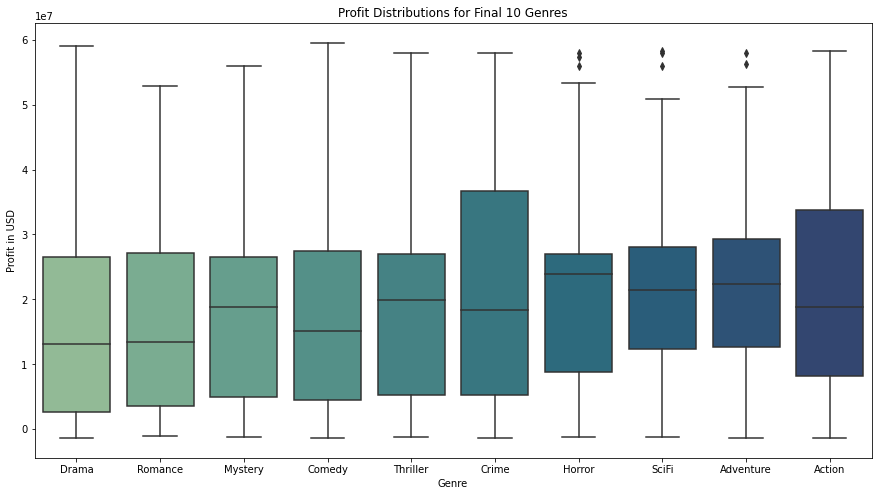

In [42]:
# Creating separate dataframes for each genre
romances = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Romance'] == 1)] 
adventures = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Adventure'] == 1)]
dramas = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Drama'] == 1)]
horrors = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Horror'] == 1)]
actions = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Action'] == 1)]
comedies = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Comedy'] == 1)]
thrillers = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Thriller'] == 1)] 
crimes = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Crime'] == 1)]
scifis = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['SciFi'] == 1)] 
mysteries = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Mystery'] == 1)]


# Creating one dataframe for each genre and their profits
combined_dfs = pd.DataFrame({'Romance': romances['total_profit'],
                             'Adventure': adventures['total_profit'],
                             'Drama': dramas['total_profit'],
                             'Horror': horrors['total_profit'],
                             'Action': actions['total_profit'],
                             'Comedy': comedies['total_profit'],
                             'Thriller': thrillers['total_profit'],
                             'Crime': crimes['total_profit'],
                             'SciFi': scifis['total_profit'],
                             'Mystery': mysteries['total_profit']})

# Creating a list of genres in order of greatest to lowest proportion of low profit movies 
# Creating this list so that visualizations can match the order of the most recent contingency table
genre_order = []
for idx, row in low_v_not_contingency.iterrows():
    genre_order.append(idx)
genre_order

### Visualizing Profit distributions

import seaborn as sns

fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data=combined_dfs, palette='crest', order = genre_order)
ax.set_title("Profit Distributions for Final 10 Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Profit in USD");
plt.show()

This visualization helps demonstrate that the overall distributions for each genre are relatively similar, which is consistent with our interpretation of the Cramer's V value. 

2. Bar Chart of Genre Frequency for Final Dataset

The bar chart below visualizes the number of movies representing each genre in the final dataset.

Resource: https://datavizpyr.com/sort-bars-in-barplot-using-seaborn-in-python/#:~:text=Sort%20Bars%20in%20Barplot%20in%20Ascending%20Order%20in,variable%20in%20the%20order%20we%20want%20to%20plot.

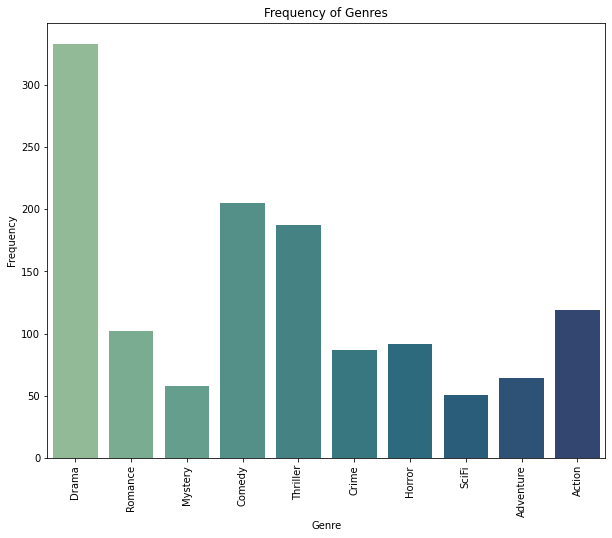

In [43]:
# Take the subset of the dataframe for only the genres included in the final dataset. 
final_genres_df = budgets_and_genre_dummys.loc [ (budgets_and_genre_dummys['Romance'] == 1) 
                                                | (budgets_and_genre_dummys['Adventure'] == 1) 
                                                | (budgets_and_genre_dummys['Drama'] == 1) 
                                                | (budgets_and_genre_dummys['Horror'] == 1) 
                                                | (budgets_and_genre_dummys['Action'] == 1) 
                                                | (budgets_and_genre_dummys['Comedy'] == 1) 
                                                | (budgets_and_genre_dummys['Thriller'] == 1) 
                                                | (budgets_and_genre_dummys['Crime'] == 1) 
                                                | (budgets_and_genre_dummys['SciFi'] == 1) 
                                                | (budgets_and_genre_dummys['Mystery'] == 1)  ]


# Create a frequency dictionary for the genres 
# (must be done manually rather than my value_counts since there are multiple genres in each row)

def freq_dictionary(dataframe):
    genre_sums = {}
    
    for col in dataframe.columns:
    
        ignored_cols = ["title", "genre_ids","total_profit",'relative_profit_cat',""]
        
        # for each genre column
        if col not in ignored_cols:
            
            # create a key in the dictionary for that genre
            # make the value equal to the total number of movies with a 1 in that column (equal to sum)
            genre_sums[col] = dataframe[col].sum()
        
    return genre_sums

genre_sums = freq_dictionary(final_genres_df)


# plot the frequency dictionary in order at which the genres appear in the final contingency table
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x = list(genre_sums.keys()), y = list(genre_sums.values()), order = genre_order, palette = 'crest')
plt.xticks(rotation = 90)
ax.set_title("Frequency of Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Frequency");

While there doesn't appear to be a particular trend in this order, it is interesting that dramas, which have the highest proportion of low profit movies, are also the most represented.

3. Stacked Bar Charts

The following barchart visualizes the proportional differences in profit categories for the genres in the final contingency table.

Resource: https://www.datasciencelearner.com/stacked-bar-graph-in-python-step/#:~:text=We%20can%20draw%20a%20stacked%20bar%20graphs%20in,seaborn%20library%20as%20well%20to%20achieve%20the%20same.

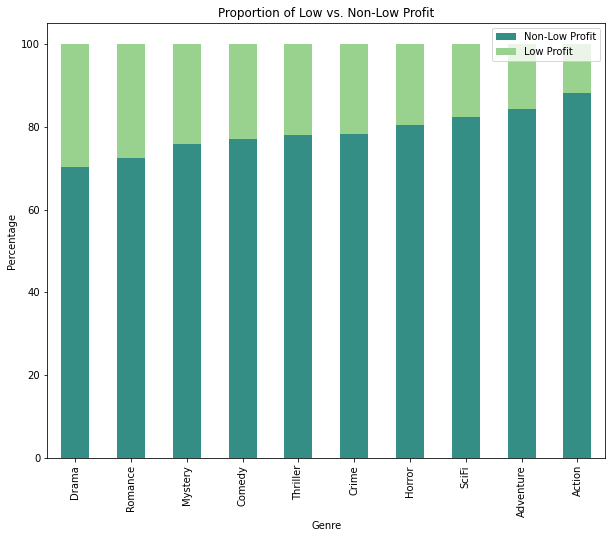

In [44]:
ax = low_v_not_contingency.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Low vs. Non-Low Profit", 
                           figsize = (10,8),
                           color = ['#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Non-Low Profit','Low Profit']);

The following bar charts visualize the proportion of high, medium, and low profit movies for all genres included in the final analysis. The only difference between the two is the order in which the genres are sorted. The former sorts from largest to smallest proportion of high profit movies, the latter sorts from largest to smallest proportion of low profit movies.

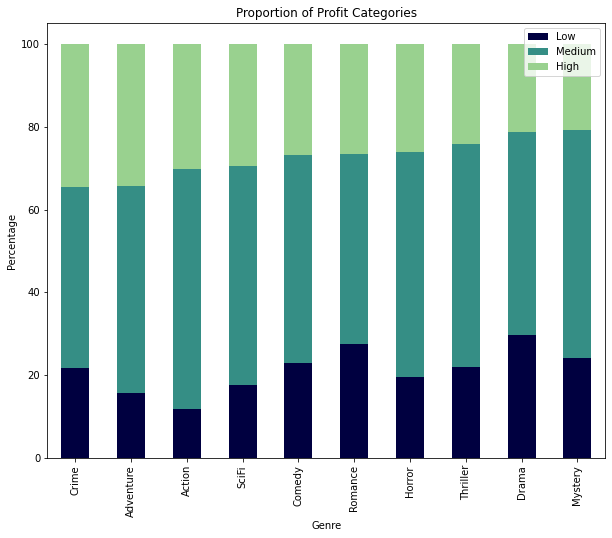

In [45]:
# Create percetange columns
contingency_table['perc_low'] = round( (contingency_table['low'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)
contingency_table['perc_medium'] = round( (contingency_table['medium'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)
contingency_table['perc_high'] = round( (contingency_table['high'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)

# Create new dataframe which only contains the percentage columns
# sort by greatest proportion of hight profit movies to lowest proportion
contingency_table_prop = contingency_table[['perc_low','perc_medium','perc_high']]
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_high', ascending = False)

# plot the percentage dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);

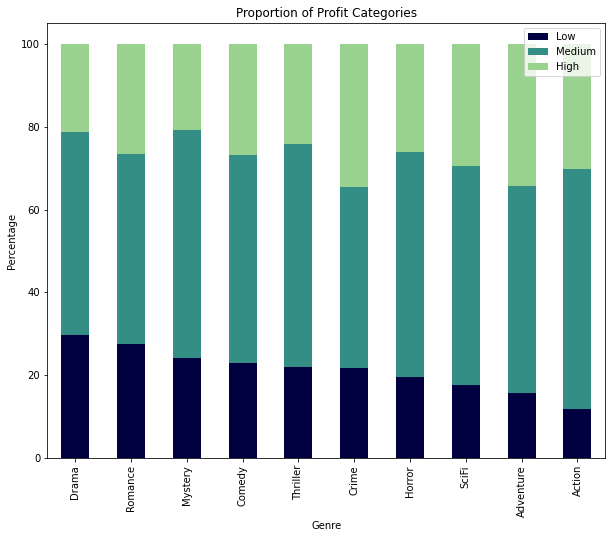

In [46]:
# re-sort proportion table from highest percentage of low profit movies to lowest proportion
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_low', ascending = False)

# plot the newly sorted dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);

### Genre (Landon)

#### Datasets and cleaning
The datasets used for this analysis were:

    - im.db (from imdb.com - accessed through sqlite3)
    - tn.budgets.csv (from The-Numbers.com)

Within the IMDB dataset, the tables movie_basics, and movie_reviews was called and merged on the primary key, "movie_id". The values in the genre column needed to be split on every comma, as many movies were classified under multiple genres. The entries were split within the column, and then for every genre in the column, a new row was created with the respective genre.

For example, if a *Lord of the Rings* movie was classified as an action *and* adventure film, *Lord of the Rings* would appear in two separate rows. The genre value would be "action" in one row, and "adventure" on the other. The resulting dataframe was trimmed so that it only contained the primary_title and genre column.

Next, the tn.budgets.csv file was loaded in using pandas. The financial columns were in a common monetary format as strings; this was rectified by using the "str.replace()" method, and then casting the columns as numeric. A new "total_profit" column was created by subtracting the production budget from the worldwide gross. This inevitably creates an *estimate* of the total_profit, as it is unknown if the entire budget was utilized. As a result, the total_profit is expected to be *at least* the current value.

To use information that otherwise is not very telling, the two tables were merged with the keys being "primary_title" and "movie".  The merged table would pair the "total_profit" column to each respective movie. After the merge, the resulting dataframe had 6,452 entries (which, as a reminder, is *not* equal to the number of movies).

Bringing back the example from above, *Lord of the Rings* would appear in two separate rows as follows:

    | primary_title      | genre     | total_profit |
    |*Lord of the Rings* | Action    | 340000000    |
    |*Lord of the Rings* | Adventure | 340000000    |

Using this data structure, it was possible to create box plots for each genre and compare them to one another. 

#### Analysis methods

In [ ]:
# Imports
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [ ]:
conn = sqlite3.connect('../data/im.db')

In [ ]:
tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
tables

In [ ]:
# Look into movie ratings
movie_ratings = pd.read_sql("""
    SELECT *
    FROM movie_ratings""", conn)
movie_ratings

In [ ]:
# Look into movie basics
movie_basics = pd.read_sql("""
    SELECT *
    FROM movie_basics""", conn)
movie_basics

In [ ]:
# Checking to see if any movie id appears more than once
pd.read_sql("""
    SELECT *
    FROM movie_basics
    GROUP BY movie_id
    HAVING COUNT(movie_id) > 1;
""", conn)

In [ ]:
# Connect the two tables
mb_mr = pd.read_sql("""
    SELECT *
    FROM movie_basics as b
    INNER JOIN movie_ratings as r
        ON b.movie_id = r.movie_id;
""", conn)
mb_mr 

In [ ]:
# Will remove duplicate column without damaging indeces
mb_mr = mb_mr.loc[:, ~mb_mr.columns.duplicated()].copy()
mb_mr

In [ ]:
# Split genres and create a new entry for each of the genre a movie falls into
### FROM Leo's EDA notebook
s = mb_mr['genres'].str.split(',').apply(Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'genre'
del mb_mr['genres']
mb_mr_genres = mb_mr.join(s)

In [ ]:
mb_mr_genres = mb_mr_genres[['primary_title', 'genre']]
mb_mr_genres.head(20)

## Load in tn.movie.budgets.csv
### Cleaning

In [ ]:
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
budgets.head()

In [ ]:
# removing $ and , from gross revenue
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",","")
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$","")
budgets['production_budget'] = budgets['production_budget'].str.replace(",","")
budgets['production_budget'] = budgets['production_budget'].str.replace("$","")

# casting the values as integers
budgets['production_budget'] = pd.to_numeric(budgets['production_budget'])
budgets['worldwide_gross'] = pd.to_numeric(budgets['worldwide_gross'])

# calculating total profit
budgets['total_profit'] =  budgets['worldwide_gross'] - budgets['production_budget']

# Keep only movie and total_profit columns
budgets = budgets[['movie', 'total_profit']]

# confirmation
budgets.head()

In [ ]:
combined = pd.merge(mb_mr_genres, budgets, left_on="primary_title", right_on="movie")
combined.drop(columns="movie", inplace=True)
combined

The duplicate values in the rows are okay to have for what I am going to
accomplish with them. I will create a boxplot where the x is the genre categories, and the y is the total_profit column associated with those genres. Before proceeding to that, I need to clean up the new table and deal with outliers.

In [ ]:
# Unclean chart for reference to visualize the outliers
sns.boxplot(x=combined['genre'], y=combined['total_profit']);

## Cleaning + dealing with outliers

In [ ]:
# Getting 25th percentile of genre counts... the max 1491 is drama
combined['genre'].value_counts().describe()

In [ ]:
# looking at genre counts... 
combined['genre'].value_counts()

In [ ]:
# remove any genre where the count is lower than 100
mask = combined['genre'].value_counts() > 100

vals_to_keep = []
for x in mask.items():
    if x[1] == True:
        vals_to_keep.append(x[0])
        
vals_to_keep

In [ ]:
# Create table where we've kept rows where the value in genre
# matched the vals_to_keep
combined = combined.loc[combined['genre'].isin(vals_to_keep)]
combined

## Charting
### Dealing with outliers using showfliers=False

In [ ]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize = (14,12))
sns.boxplot(ax=ax, x=combined['genre'],
            y=combined['total_profit'],
            showfliers=False)

plt.style.use('seaborn-muted')

# scale y axis to millions
scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(-250000000, 1000000000)

# add title/labels/ticks/grid
ax.set_title('Profit Distribution by Genre (USD)', size=24)
plt.xlabel("Genre", size = 20)
plt.ylabel("Total Profit (in millions)", size=20)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.2)

# create red area in negative y
plt.axhline(y=[-1000000], alpha=0.3, color='red', fillstyle='bottom')
plt.axhspan(-2500000000, 0, alpha=0.15, color='red')

# saves fig
#plt.savefig('../resources/charts/prof_genre_box.png', dpi=fig.dpi)
;

### Narrow down genres

In [ ]:
# look at what genres have the top median profits
med_combined = combined.groupby('genre', sort='total_profit').median()
med_combined = med_combined.sort_values(by='total_profit', ascending=False)
med_combined_8 = med_combined.head(8)
med_combined_8

In [ ]:
# Preparing to keep only the top 8 median genres
vals_to_keep = []
for x in med_combined_8.iterrows():
    vals_to_keep.append(x[0])
        
vals_to_keep

In [ ]:
# Create table where we've kept rows where the value in genre
# matched the vals_to_keep
top_8_combined = combined.loc[combined['genre'].isin(vals_to_keep)]
top_8_combined

## Charting the 8 genres with the highest median profit

In [ ]:
fig, ax = plt.subplots(figsize = (14,12))
sns.boxplot(ax=ax, x=top_8_combined['genre'],
            y=top_8_combined['total_profit'],
            showfliers=False)

plt.style.use('seaborn-muted')

# scale y axis to millions
scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(-250000000, 1000000000)

# title/labels/ticks
ax.set_title('Profit Distribution by Genre (USD)', size=24)
plt.xlabel("Genre", size = 20)
plt.ylabel("Total Profit (in millions)", size=20)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.2)

# adding negative y color
plt.axhline(y=[-1000000], alpha=0.3, color='red', fillstyle='bottom')
plt.axhspan(-250000000, 0, alpha=0.15, color='red')

# save fig
#plt.savefig('../resources/charts/top8_prof_genre_box.png', bbox_inches='tight')
;

## Charting the top 8 WITH outliers

In [ ]:
fig, ax = plt.subplots(figsize = (14,12))
sns.boxplot(ax=ax, x=top_8_combined['genre'],
            y=top_8_combined['total_profit'],
            showfliers=True)

plt.style.use('seaborn-muted')

# scale y axis to millions
scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(-250000000, 2250000000)

# title/labels/ticks
ax.set_title('Profit Distribution by Genre (USD)', size=24)
plt.xlabel("Genre", size = 20)
plt.ylabel("Total Profit (in millions)", size=20)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.2)

# adding negative y color
plt.axhline(y=[-1000000], alpha=0.3, color='red', fillstyle='bottom')
plt.axhspan(-2500000000, 0, alpha=0.15, color='red')

# saves fig
#plt.savefig('../resources/charts/top8_outlier_prof_genre_box.png', dpi=fig.dpi)
;

Creating a small table with top 8 performing genres that displays their median income

In [ ]:
# rename total profit column to median profit
med_combined_8 = med_combined_8.rename({'total_profit': 'median_profit'},
                                       axis=1)
med_combined_8

#### Conclusion / Suggestion

#### What limitations are there?